# Binary Classification with Feature Selection

### 1. Importing Libraries and Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, auc

import os
os.chdir('E:/PGP-DSE/Capstone Project/Group 2/OnlineNewsPopularity')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

### 2. Reading the dataset

In [2]:
df = pd.read_csv('ONPClass.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,class
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


In [3]:
df = df.drop(['url','timedelta'],axis=1)

In [4]:
### Get the highly correlated features

corr_val = df.corr()

correlated_features = set()
correlation_matrix = corr_val.drop('class', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

{'LDA_00', 'kw_max_max', 'avg_positive_polarity', 'LDA_04', 'rate_negative_words', 'kw_avg_min', 'LDA_02', 'abs_title_sentiment_polarity', 'n_non_stop_unique_tokens', 'rate_positive_words', 'self_reference_avg_shares', 'n_non_stop_words'}


## 3. Custom Functions
- These functions are created as they are to be used repeatedly and to reduce the lines of code


In [5]:
# train test split
def perform_train_test_split(x,y,size):
    return train_test_split(x, y, test_size = size, random_state = 0)


# function for scaling the data for train test split
def std_data(xtrain,xtest):
    sc = StandardScaler()
    scaled = sc.fit(xtrain)
    scaled_train = sc.transform(xtrain)
    scaled_test = sc.transform(xtest)
    return scaled_train, scaled_test

# function to scale whole data
def std_data_n(x):
    sc = StandardScaler()
    scaled = sc.fit_transform(x)
    return scaled


# function to apply rfecv onto the dataset
def apply_rfecv(x,y):

    RF = RandomForestClassifier(random_state=0)
    rfecv = RFECV(estimator= RF, step = 1, cv=5, scoring='roc_auc')
    rfecv.fit(x, y)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    rfe_features = pd.DataFrame({'features': x.columns, 'rank':rfecv.ranking_}).sort_values(by = 'rank')
    sel_features = rfe_features[rfe_features['rank']==1]['features'].to_list()
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return sel_features


# function for applying random search cv
def random_search_cv(x,y,model,params):
    RS = RandomizedSearchCV(model, params, cv = 5, scoring = 'roc_auc', random_state = 0)
    RS.fit(x,y)
    return RS.best_params_, RS.best_estimator_, RS.best_score_

# function for applying grid search cv
def grid_search_cv(x,y,model,params):
    GS = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc', random_state = 0)
    GS.fit(x,y)
    return GS.best_params_


# function to fit the model, predict the labels, obtain different metrics and plot roc auc curve
def fit_predict(xtrain,xtest,ytrain,ytest,models):
    
    for name, model in models:
        
        model.fit(xtrain,ytrain)
        y_pred_train = model.predict(xtrain)
        y_pred_test = model.predict(xtest)

        probas_train = model.predict_proba(xtrain)[:,1]
        print('\n Train ROC AUC Score: ', roc_auc_score(ytrain,probas_train))
        
        probas_test = model.predict_proba(xtest)[:,1]
        print('\n Test ROC AUC Score: ', roc_auc_score(ytest,probas_test))

        fpr, tpr, thresholds = roc_curve(ytest,probas_test)
        
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        plt.plot(fpr, tpr, color='b', label=r'ROC (AUC = %0.2f )' % (roc_auc_score(ytest,probas_test)), lw=2, alpha=.8)

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title('ROC of %s' % (name),fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()


# function for applying various models
def implement_cv(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        final.update({'Model': names , 'roc_auc_score': auc})
    return pd.DataFrame(final)

## 4. Initializing and Building the Models

### 4.1 Implementing base model Logistic Regression

In [6]:
X = df.drop(['class','avg_negative_polarity', 'min_negative_polarity', 
             'max_negative_polarity','abs_title_subjectivity','weekday_is_friday'],axis = 1 )

X = X.drop(correlated_features, axis = 1)

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.2) # splitting the dataset

train, test = std_data(X_train, X_test) # standardize the train and test sets


 Train ROC AUC Score:  0.7022279214445206

 Test ROC AUC Score:  0.6985980710506732


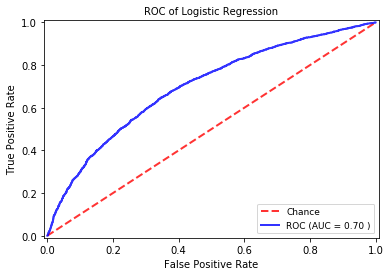

In [7]:
LOGREG = LogisticRegression(random_state = 0)

models = [('Logistic Regression', LOGREG)]

fit_predict(train, test, y_train, y_test, models) # implementing the model

### 4.2 Implementing Ensemble Models


 Train ROC AUC Score:  1.0

 Test ROC AUC Score:  0.7166684596860284


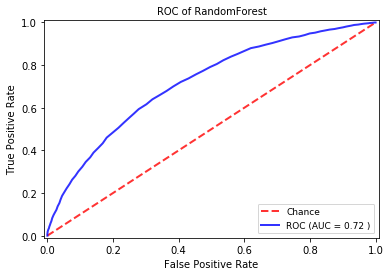

In [8]:
RF = RandomForestClassifier(random_state = 0)
models = [('RandomForest', RF)]
fit_predict(train, test, y_train, y_test,models)


 Train ROC AUC Score:  1.0

 Test ROC AUC Score:  0.7168203146335206


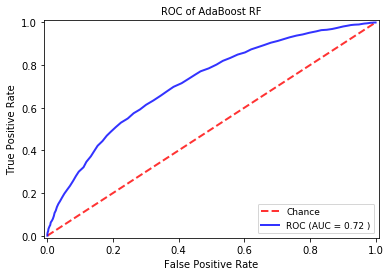

In [13]:
AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 25, random_state = 0)
models = [('AdaBoost RF', AB_RF)]
fit_predict(train, test, y_train, y_test,models)


 Train ROC AUC Score:  0.7474762418066377

 Test ROC AUC Score:  0.7213924821774936


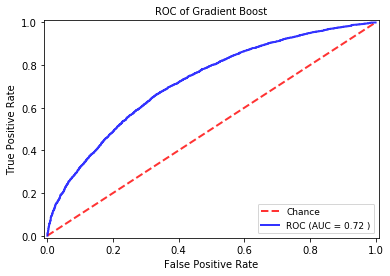

In [15]:
GB = GradientBoostingClassifier(random_state = 0)

models = [('Gradient Boost', GB)]

fit_predict(train, test, y_train, y_test, models)

### 4.3 Tuning Random Forest

In [18]:
# Number of trees in random forest
n_estimators = np.arange(30,50,10)

# Maximum number of levels in tree
max_depth =  np.arange(2,9,2)
#[int(x) for x in np.linspace(3, 30, num = 11)]
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7,9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4, 5]


rf_params = {'n_estimators': n_estimators, 'criterion':['gini','entropy'], 
             'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split }

rfparam, rfestimator, rfscore = random_search_cv(train,y_train,RF,rf_params)

print(rfparam)

{'n_estimators': 40, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'gini'}



 Train ROC AUC Score:  0.7700378412296154

 Test ROC AUC Score:  0.713725764797025


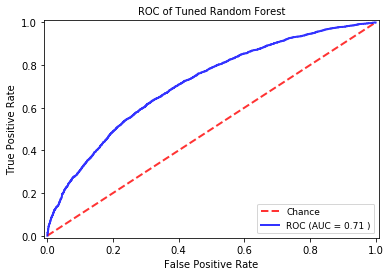

In [24]:
tuned_RF = rfestimator

models = [('Tuned Random Forest', tuned_RF)]

fit_predict(train, test, y_train, y_test, models)

## 5. Feature Selection Method

### 5.1 Recursive Feature Elimination

In [25]:
X = df.drop(['class','avg_negative_polarity','min_negative_polarity','max_negative_polarity',
             'abs_title_subjectivity','weekday_is_friday'], axis = 1 )
Y = df['class']

In [ ]:
sel_features = apply_rfecv(X,Y)

In [27]:
# 47 features
sel_features = ['n_tokens_title', 'self_reference_max_shares', 'self_reference_avg_shares', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_saturday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'kw_avg_avg', 'self_reference_min_shares', 'kw_min_avg', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_entertainment', 'kw_max_avg', 'abs_title_sentiment_polarity', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'data_channel_is_socmed']

In [28]:
X = X[sel_features]

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.2)

train, test = std_data(X_train, X_test)

### 5.1.1 Logistic Regression


 Train ROC AUC Score:  0.7042810366825208

 Test ROC AUC Score:  0.7017009281898927


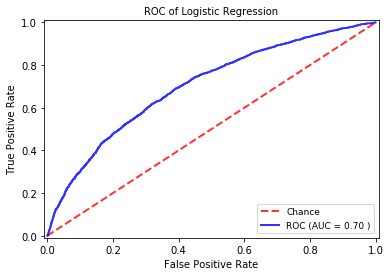

In [29]:
LOGREG = LogisticRegression(random_state = 0)

models = [('Logistic Regression', LOGREG)]

fit_predict(train, test, y_train, y_test, models)

### 5.1.2 Decision Tree


 Train ROC AUC Score:  1.0

 Test ROC AUC Score:  0.5779046436230789


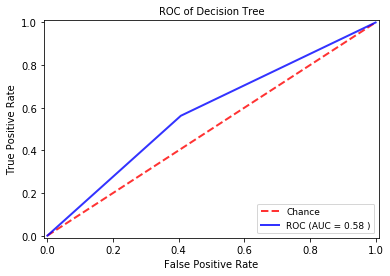

In [30]:
DT = DecisionTreeClassifier(random_state = 0)

models = [('Decision Tree', DT)]

fit_predict(train, test, y_train, y_test,models)

## Ensemble Models

### 5.1.3 Random Forest


 Train ROC AUC Score:  1.0

 Test ROC AUC Score:  0.7168368019239839


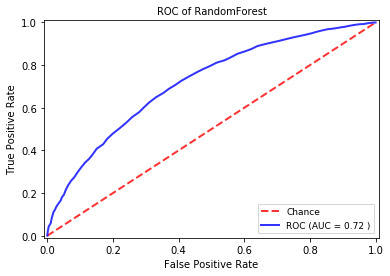

In [31]:
RF = RandomForestClassifier(random_state = 0)
models = [('RandomForest', RF)]
fit_predict(train, test, y_train, y_test,models)

### 5.1.4 AdaBoost Decision Forest


 Train ROC AUC Score:  1.0

 Test ROC AUC Score:  0.5780279481853476


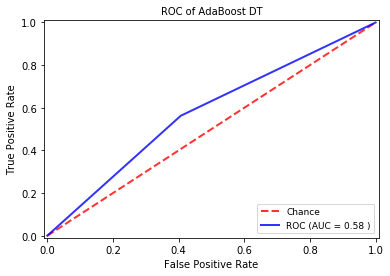

In [32]:
AB_DT = AdaBoostClassifier(base_estimator = DT, n_estimators = 20, random_state = 0)
models = [('AdaBoost DT', AB_DT)]
fit_predict(train, test, y_train, y_test,models)

### 5.1.5 AdaBoost Random Forest


 Train ROC AUC Score:  1.0

 Test ROC AUC Score:  0.7170903815439106


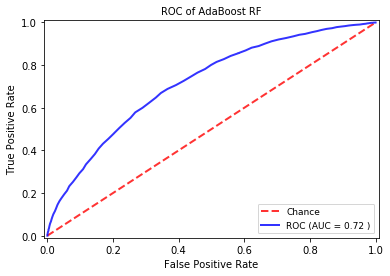

In [33]:
AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 20, random_state = 0)
models = [('AdaBoost RF', AB_RF)]
fit_predict(train, test, y_train, y_test,models)

### 5.1.6 Gradient Boost


 Train ROC AUC Score:  0.7507193408356951

 Test ROC AUC Score:  0.7255878610255095


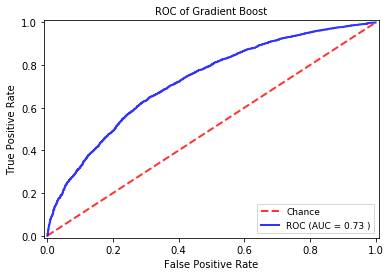

In [34]:
GB = GradientBoostingClassifier(random_state = 0)

models = [('Gradient Boost', GB)]

fit_predict(train, test, y_train, y_test, models)

###  Hyperparameter tuning using RandomizedSearchCV

### Tuning Decision Tree

In [35]:

# Maximum number of levels in tree
max_depth = [3,5,7,8]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4,5]

dt_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,
             'criterion':['gini','entropy'], 'min_samples_split' : min_samples_split}

dtparam, dtestimator, dtscore = random_search_cv(train,y_train,DT,dt_params)

print(dtparam)

{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'entropy'}


### 5.1.7 Tuned Decision Tree


 Train ROC AUC Score:  0.72236760151398

 Test ROC AUC Score:  0.6834255942586035


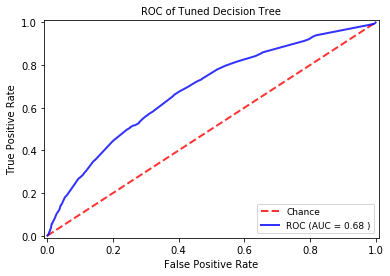

In [36]:
tunedDT = dtestimator
models = [('Tuned Decision Tree', tunedDT)]
fit_predict(train, test, y_train, y_test,models)

### Tuning Random Forest

In [38]:
# Number of trees in random forest
n_estimators = np.arange(10,50,20)

# Maximum number of levels in tree
max_depth = [3,5,6,7]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4, 5]


rf_params = {'n_estimators': n_estimators, 'criterion':['gini','entropy'],
             'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split }

rfparam, rfestimator, rfscore = random_search_cv(train,y_train,RF,rf_params)

print('Best Parameters for Random Forest:\n',rfparam)


Best Parameters for Random Forest:
 {'n_estimators': 30, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'gini'}


### 5.1.8 Tuned Random Forest


 Train ROC AUC Score:  0.7528170944607212

 Test ROC AUC Score:  0.714190496318369


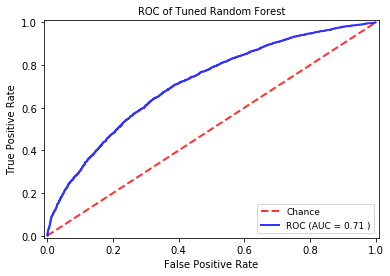

In [39]:
tunedRF = rfestimator

models = [('Tuned Random Forest', tunedRF)]

fit_predict(train, test, y_train, y_test, models)

### 5.1.9 Boosting Tuned Decision Tree


 Train ROC AUC Score:  0.8798553428309259

 Test ROC AUC Score:  0.6480672312237452


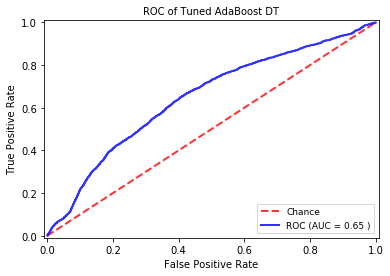

In [40]:
tunedAB_DT = AdaBoostClassifier(base_estimator = tunedDT, n_estimators = 20, random_state = 0)
models = [('Tuned AdaBoost DT', tunedAB_DT)]
fit_predict(train, test, y_train, y_test,models)

### 5.1.10 Boosting Tuned Random Forest


 Train ROC AUC Score:  0.9269072831170576

 Test ROC AUC Score:  0.7261343924242492


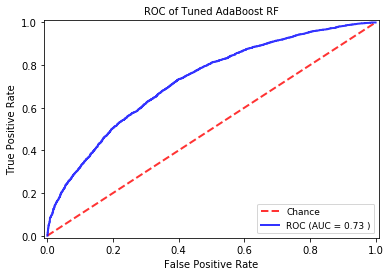

In [41]:
tunedAB_RF = AdaBoostClassifier(base_estimator = tunedRF, n_estimators = 20, random_state = 0)
models = [('Tuned AdaBoost RF', tunedAB_RF)]
fit_predict(train, test, y_train, y_test, models)

### 5.1.11 Tuned Gradient Boost


 Train ROC AUC Score:  0.754746716856279

 Test ROC AUC Score:  0.7258452282662182


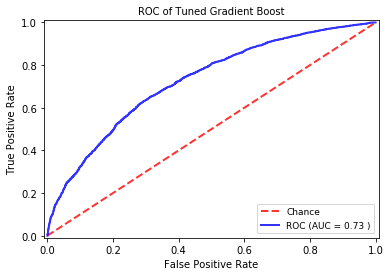

In [47]:
tunedGB = GradientBoostingClassifier(n_estimators = 120, random_state = 0)

models = [('Tuned Gradient Boost', tunedGB)]

fit_predict(train, test, y_train, y_test, models)

### 6. Implementing models with cross validation

In [47]:


models = []
#models.append(('Logistic Regression',LOGREG))
#models.append(('Decision Tree', DT))
#models.append(('Random Forest', RF))
#models.append(('AdaBoost DT', AB_DT))
#models.append(('AdaBoost RF', AB_RF))
#models.append(('Gradient Boost', GB))

#models.append(('Tuned Decision Tree', tunedDT))
#models.append(('Tuned Random Forest', tunedRF))

#models.append(('Tuned AdaBoost DT', tunedAB_DT))
#models.append(('Tuned AdaBoost RF', tunedAB_RF))
models.append(('Tuned Gradient Boost', tunedGB))

# function call to implement the models
implement_cv(train,y_train,models)

,Model,roc_auc_score
0,Tuned Gradient Boost,0.712997
